In [16]:
# Generate plots for
# Main Text Fig. 3 of "Noise-Enabled Goal Attainment in Crowded Collectives"

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)  # creates "figures" if missing

end_time = 300
time_cutoff = end_time * 0.25

plt.style.use('./traffic_figures.mplstyle')

## Import experiment data

In [17]:
exp_df = pd.read_csv("../experiment_data/experiment_goal_rates.csv")


In [18]:
exp_df

,trial_id,noise,num_robots,latesim_goal_rate
0,21.0,0.00,3,0.00000
1,21.0,0.00,5,0.00000
2,21.0,0.00,7,0.00000
3,21.0,0.25,3,0.04889
4,21.0,0.25,5,0.03556
...,...,...,...,...
181,43.0,1.25,10,0.09333
182,43.0,1.50,7,0.06222
183,43.0,1.50,10,0.07556
184,43.0,1.50,15,0.13778


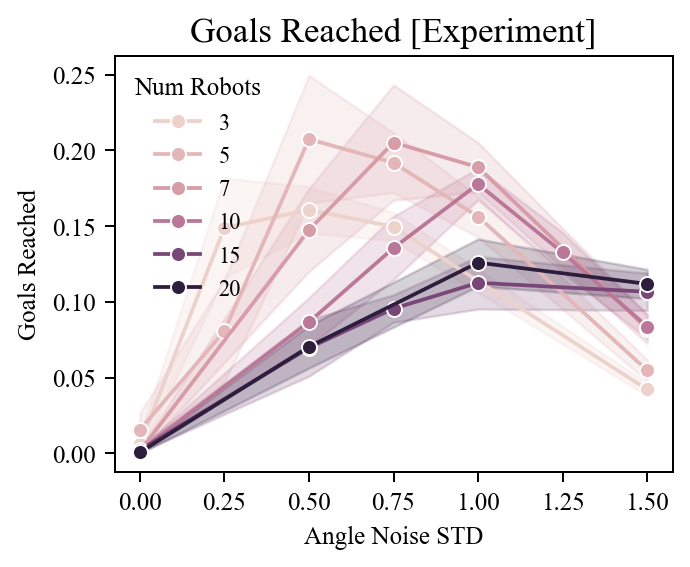

In [19]:
# Plotting with Seaborn
plt.figure(figsize=(4, 3))

sns.lineplot(data=exp_df[~(exp_df['noise'] == -1)], x='noise', y='latesim_goal_rate', 
    hue='num_robots', 
    marker='o',
    errorbar='se',
    legend='full')

# Add plot labels and title
plt.title('Goals Reached [Experiment]')
plt.xlabel('Angle Noise STD')
plt.ylabel('Goals Reached')
plt.legend(title='Num Robots')

# Show the plot
plt.show()

## Import Simulation Data

In [20]:
data_dir = '../simulation_data/'
sim_name = 'fig3_simulation_data'
df_file_name = data_dir + sim_name + ".txt"

sim_df = pd.read_csv(df_file_name, index_col = False)

end_time = np.max(sim_df['sim_time'])
sim_time_per_trial = end_time # 10 min = 600 seconds
sim_df['goal_age'] = (sim_df['sim_time'] - sim_df['goal_birth_time']) / end_time
sim_df['sim_time'] = np.round(sim_df["sim_time"], 4)
sim_df['robot_id'] = sim_df['robot_id'].astype('int')

sim_df

,trial,periodic,num_robots,noise,noise_prob,sim_time,robot_id,x_pos,y_pos,angle,goal_x_pos,goal_y_pos,goal_birth_time,goals_reached,stopped,nearby_robot,addtl_data,goal_age
0,0,0,1,0.0,1.0,0.0,0,0.16,-0.36,2.03,0.47,-0.36,0,0,0,-1,NaN,0.000000
1,0,0,1,0.0,1.0,75.0,0,0.28,-0.15,-0.43,0.33,-0.19,73,15,0,-1,NaN,0.006667
2,0,0,1,0.0,1.0,150.0,0,0.05,0.42,-2.77,-0.47,0.16,149,31,0,-1,NaN,0.003333
3,0,0,1,0.0,1.0,225.0,0,0.14,0.11,-0.26,-0.25,0.01,225,47,0,-1,NaN,0.000000
4,0,0,1,0.0,1.0,300.0,0,0.35,0.03,2.28,-0.11,0.40,298,60,0,-1,NaN,0.006667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163187,99,0,20,1.5,1.0,300.0,15,-0.25,0.13,1.45,-0.43,0.56,191,2,0,-1,NaN,0.363333
163188,99,0,20,1.5,1.0,300.0,16,-0.03,0.88,-1.01,0.40,0.56,122,2,0,-1,NaN,0.593333
163189,99,0,20,1.5,1.0,300.0,17,0.11,0.02,2.02,-0.49,-0.29,81,1,1,1,NaN,0.730000
163190,99,0,20,1.5,1.0,300.0,18,-0.15,0.42,0.25,0.35,-0.27,254,2,0,-1,NaN,0.153333


In [21]:
sim_df_ends = sim_df[sim_df['sim_time'] == end_time].drop(columns=['nearby_robot']).drop_duplicates()

sim_df_endstats_trial = sim_df_ends.groupby(['trial', 'noise', 'num_robots', 'periodic']).agg(avg_goal_age_trial = ('goal_age', 'mean'), 
                                                                                              goals_reached_trial = ('goals_reached', 'sum'),
                                                                                              ).reset_index()

sim_df_endstats = sim_df_endstats_trial.groupby(['noise', 'num_robots', 'periodic']).agg(avg_goal_age = ('avg_goal_age_trial', 'mean'),
                                                                                std_goal_age = ('avg_goal_age_trial', 'std'), # sample std by default 
                                                                                avg_goals_reached = ('goals_reached_trial', 'mean'),
                                                                                std_goals_reached = ('goals_reached_trial', 'std'),
                                                                                count = ('goals_reached_trial', 'count')).reset_index()

## Side by side comparison

In [22]:
def goals_reached_between(df, time_a, time_b, extra_variables = []):
    goalsreached = df[(df['sim_time'].isin([time_a, time_b]))][['trial', 'periodic', 'num_robots', 'noise', 'sim_time', 'robot_id', 'goals_reached'] + extra_variables].drop_duplicates()
    goalsreached = goalsreached.pivot(index=['trial', 'periodic', 'num_robots', 'noise', 'robot_id'] + extra_variables, columns='sim_time', values='goals_reached').reset_index() # cast data for two times into two separate columns
    
    # goals each robot in each trial reaches between time and b
    goalsreached['goals_in_interval'] = goalsreached[time_b] - goalsreached[time_a]

    # goals all robots together reach
    goalsreached_trial = goalsreached.groupby(['trial', 'noise', 'num_robots', 'periodic'] + extra_variables, observed=False).agg(goals_reached_trial = (time_b, 'sum'), 
                                                                                                            latesim_goals_trial = ('goals_in_interval', 'sum')).reset_index()
    
    return goalsreached_trial

In [23]:
# sim_df
sim_df_latesim_trial = goals_reached_between(sim_df, time_cutoff, end_time, extra_variables = [])
sim_df_latesim_trial['latesim_goal_rate'] = sim_df_latesim_trial['latesim_goals_trial'] / (end_time - time_cutoff)
sim_df_latesim_trial

,trial,noise,num_robots,periodic,goals_reached_trial,latesim_goals_trial,latesim_goal_rate
0,0,0.0,1,0,60,45,0.200000
1,0,0.0,3,0,12,0,0.000000
2,0,0.0,5,0,3,0,0.000000
3,0,0.0,7,0,10,0,0.000000
4,0,0.0,10,0,2,0,0.000000
...,...,...,...,...,...,...,...
3495,99,1.5,5,0,23,16,0.071111
3496,99,1.5,7,0,28,22,0.097778
3497,99,1.5,10,0,27,22,0.097778
3498,99,1.5,15,0,44,33,0.146667


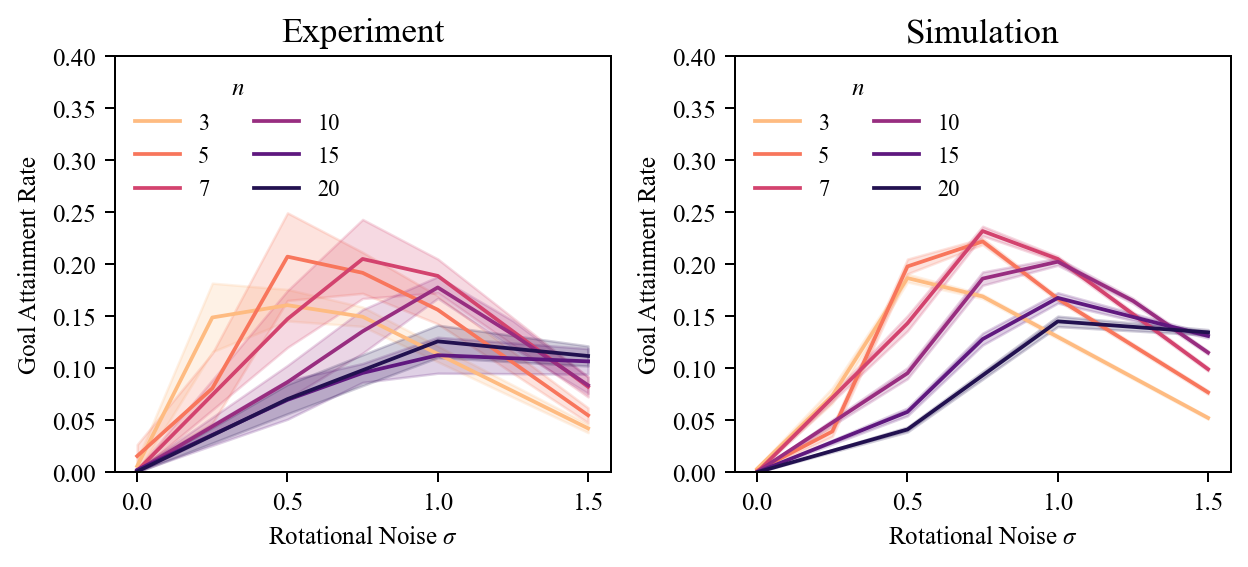

In [24]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.subplots_adjust(wspace=0.25) 

# Left plot: experiment data
sns.lineplot(
    data=exp_df[~(exp_df['noise'] == -1)
                       & (exp_df['num_robots'] > 1)],
    x='noise',
    y='latesim_goal_rate',
    hue='num_robots',
    errorbar='se',
    legend='full',
    palette=sns.color_palette("magma_r"),
    ax=axes[0]
)

axes[0].set_title('Experiment')
axes[0].set_xlabel('Rotational Noise $\sigma$')
axes[0].set_ylabel('Goal Attainment Rate')
axes[0].set_ylim([0,0.4])
axes[0].legend(title='$n$', loc = "upper left", ncol = 2)

# Right plot: data from matching simulations
sns.lineplot(
    data=sim_df_latesim_trial[sim_df_latesim_trial['num_robots'] > 1],
    x='noise',
    y='latesim_goal_rate',
    hue='num_robots',
    palette=sns.color_palette("magma_r"),
    errorbar='se',
    legend='full',
    ax=axes[1]
)

axes[1].set_title('Simulation')
axes[1].set_xlabel('Rotational Noise $\sigma$')
axes[1].set_ylabel('Goal Attainment Rate')
axes[1].set_ylim([0, 0.4])
axes[1].legend(title='$n$', loc = "upper left", ncol = 2)

plt.savefig("figures/fig3_comparison.png", dpi = 600, bbox_inches='tight')

plt.show()


Text(0, 0.5, 'Optimal Noise Level $\\sigma$')

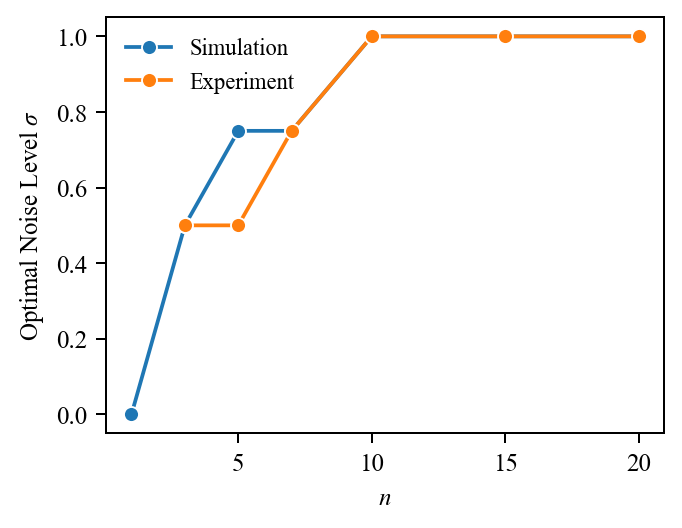

In [25]:
plt.figure(figsize=(4, 3))

sim_latesim_means = sim_df_latesim_trial.groupby(['noise', 'num_robots'])['latesim_goal_rate'].mean().reset_index()
sim_latesim_means.loc[sim_latesim_means.groupby('num_robots').agg("idxmax")['latesim_goal_rate']]

exp_df_latesim_means = exp_df[exp_df['noise'] > -1].\
    groupby(['noise', 'num_robots'])['latesim_goal_rate'].mean().reset_index()


sns.lineplot(
    data=sim_latesim_means.loc[sim_latesim_means.groupby('num_robots').agg("idxmax")['latesim_goal_rate']],
    x='num_robots',
    y='noise',
    # hue='num_robots',
    # palette=sns.color_palette("magma_r"),
    errorbar='se',
    label='Simulation',
    # ax=axes[1]
    marker='o'
)

sns.lineplot(
    data=exp_df_latesim_means.loc[exp_df_latesim_means.groupby('num_robots').agg("idxmax")['latesim_goal_rate']],
    x='num_robots',
    y='noise',
    # hue='num_robots',
    # palette=sns.color_palette("magma_r"),
    errorbar='se',
    label='Experiment',
    # ax=axes[1]
    marker='o'
)

plt.legend()
plt.xlabel("$n$")
plt.ylabel("Optimal Noise Level $\sigma$")
